In [2]:
import pandas as pd

# Load the dataset
file_path = '/content/MarketPricePrediction.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


<ipython-input-3-f11aa326b77a>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


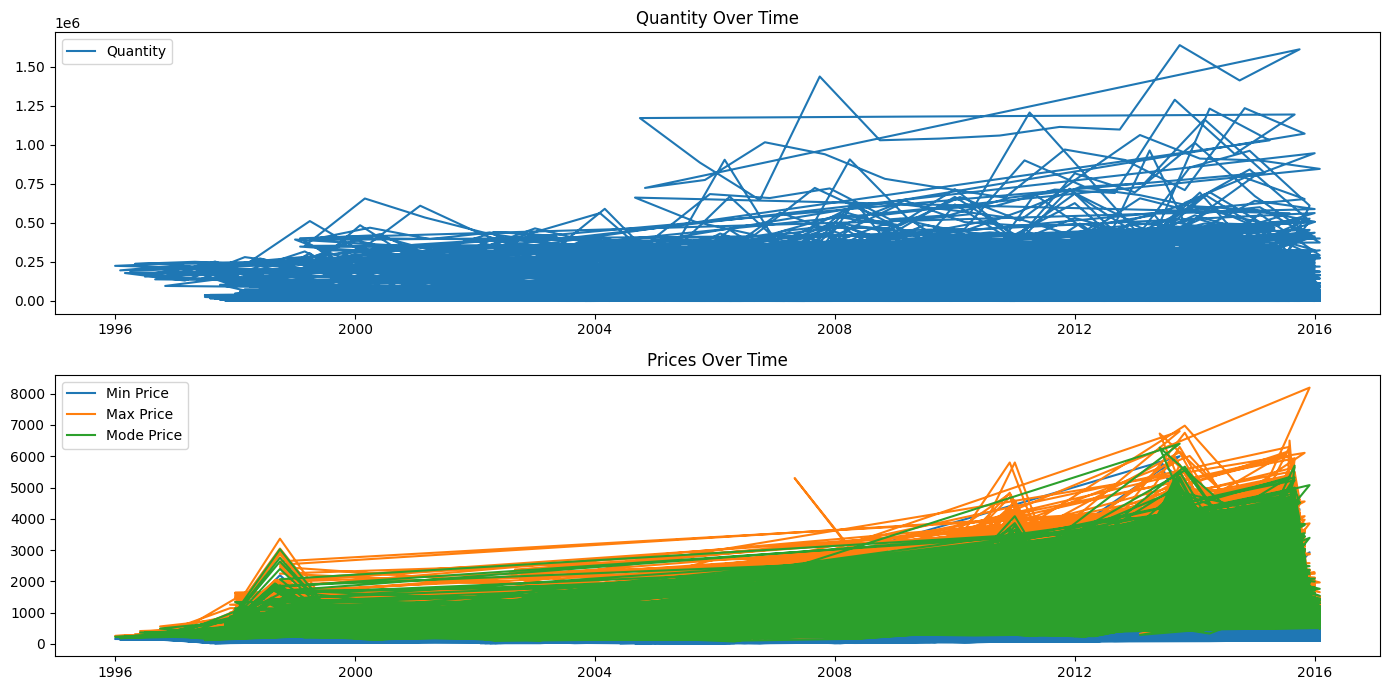

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Plot the time series data for quantity and prices
plt.figure(figsize=(14, 7))

# Plot quantity
plt.subplot(2, 1, 1)
plt.plot(df['quantity'], label='Quantity')
plt.title('Quantity Over Time')
plt.legend()

# Plot priceMin, priceMax, and priceMod
plt.subplot(2, 1, 2)
plt.plot(df['priceMin'], label='Min Price')
plt.plot(df['priceMax'], label='Max Price')
plt.plot(df['priceMod'], label='Mode Price')
plt.title('Prices Over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# Create lagged features
df['quantity_lag1'] = df['quantity'].shift(1)
df['priceMin_lag1'] = df['priceMin'].shift(1)
df['priceMax_lag1'] = df['priceMax'].shift(1)
df['priceMod_lag1'] = df['priceMod'].shift(1)

# Create rolling mean features
df['quantity_roll_mean'] = df['quantity'].rolling(window=3).mean()
df['priceMin_roll_mean'] = df['priceMin'].rolling(window=3).mean()
df['priceMax_roll_mean'] = df['priceMax'].rolling(window=3).mean()
df['priceMod_roll_mean'] = df['priceMod'].rolling(window=3).mean()

# Drop rows with missing values created by shifting and rolling
df.dropna(inplace=True)

# Display the first few rows of the dataframe after feature engineering
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,quantity_lag1,priceMin_lag1,priceMax_lag1,priceMod_lag1,quantity_roll_mean,priceMin_roll_mean,priceMax_roll_mean,priceMod_roll_mean
date,,,,,,,,,,,,,,,,,
2010-01-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,900.0,487.0,638.0,563.0,1346.666667,724.666667,907.666667,823.000000
2011-01-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,790.0,1283.0,1592.0,1460.0,645.000000,1612.333333,1993.333333,1818.666667
2012-01-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,245.0,3067.0,3750.0,3433.0,690.000000,1624.333333,2009.333333,1832.666667
2013-01-01,ABOHAR(PB),January,2013,675,1327,1900,1605,PB,ABOHAR,1035.0,523.0,686.0,605.0,651.666667,1639.000000,2112.000000,1881.000000
2014-01-01,ABOHAR(PB),January,2014,440,1025,1481,1256,PB,ABOHAR,675.0,1327.0,1900.0,1605.0,716.666667,958.333333,1355.666667,1155.333333


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import pickle

# Load the dataset
file_path = '/content/MarketPricePrediction.csv'
df = pd.read_csv(file_path)

# Data preprocessing steps
df['date'] = pd.to_datetime(df['date'], format='%B-%Y')

# Create lagged features
df['quantity_lag1'] = df['quantity'].shift(1)
df['priceMin_lag1'] = df['priceMin'].shift(1)
df['priceMax_lag1'] = df['priceMax'].shift(1)
df['priceMod_lag1'] = df['priceMod'].shift(1)

# Create rolling mean features
df['quantity_roll_mean'] = df['quantity'].rolling(window=3).mean()
df['priceMin_roll_mean'] = df['priceMin'].rolling(window=3).mean()
df['priceMax_roll_mean'] = df['priceMax'].rolling(window=3).mean()
df['priceMod_roll_mean'] = df['priceMod'].rolling(window=3).mean()

# Drop rows with missing values created by shifting and rolling
df.dropna(inplace=True)

# Define features and target variables
X = df[['quantity_lag1', 'priceMin_lag1', 'priceMax_lag1', 'priceMod_lag1', 'quantity_roll_mean', 'priceMin_roll_mean', 'priceMax_roll_mean', 'priceMod_roll_mean']]
y_quantity = df['quantity']
y_priceMin = df['priceMin']
y_priceMax = df['priceMax']
y_priceMod = df['priceMod']

# Split the data into training and testing sets
X_train, X_test, y_quantity_train, y_quantity_test = train_test_split(X, y_quantity, test_size=0.2, shuffle=False)
y_priceMin_train, y_priceMin_test = train_test_split(y_priceMin, test_size=0.2, shuffle=False)
y_priceMax_train, y_priceMax_test = train_test_split(y_priceMax, test_size=0.2, shuffle=False)
y_priceMod_train, y_priceMod_test = train_test_split(y_priceMod, test_size=0.2, shuffle=False)

# Define the parameter grid for RandomForest
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Train and fine-tune models
def train_model(X_train, y_train):
    rf = RandomForestRegressor()
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

best_rf_quantity = train_model(X_train, y_quantity_train)
best_rf_priceMin = train_model(X_train, y_priceMin_train)
best_rf_priceMax = train_model(X_train, y_priceMax_train)
best_rf_priceMod = train_model(X_train, y_priceMod_train)

# Save the models
with open('best_rf_quantity.pkl', 'wb') as f:
    pickle.dump(best_rf_quantity, f)
with open('best_rf_priceMin.pkl', 'wb') as f:
    pickle.dump(best_rf_priceMin, f)
with open('best_rf_priceMax.pkl', 'wb') as f:
    pickle.dump(best_rf_priceMax, f)
with open('best_rf_priceMod.pkl', 'wb') as f:
    pickle.dump(best_rf_priceMod, f)

# Evaluate the models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

mae_quantity, mse_quantity, rmse_quantity = evaluate_model(best_rf_quantity, X_test, y_quantity_test)
mae_priceMin, mse_priceMin, rmse_priceMin = evaluate_model(best_rf_priceMin, X_test, y_priceMin_test)
mae_priceMax, mse_priceMax, rmse_priceMax = evaluate_model(best_rf_priceMax, X_test, y_priceMax_test)
mae_priceMod, mse_priceMod, rmse_priceMod = evaluate_model(best_rf_priceMod, X_test, y_priceMod_test)

print(f"Fine-tuned Quantity - MAE: {mae_quantity}, MSE: {mse_quantity}, RMSE: {rmse_quantity}")
print(f"Fine-tuned PriceMin - MAE: {mae_priceMin}, MSE: {mse_priceMin}, RMSE: {rmse_priceMin}")
print(f"Fine-tuned PriceMax - MAE: {mae_priceMax}, MSE: {mse_priceMax}, RMSE: {rmse_priceMax}")
print(f"Fine-tuned PriceMod - MAE: {mae_priceMod}, MSE: {mse_priceMod}, RMSE: {rmse_priceMod}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fine-tuned Quantity - MAE: 15437.12377238627, MSE: 1216576270.7937057, RMSE: 34879.45341879236
Fine-tuned PriceMin - MAE: 182.3374327628362, MSE: 101512.22917794621, RMSE: 318.60983848265926
Fine-tuned PriceMax - MAE: 344.69441796390686, MSE: 292630.3099489168, RMSE: 540.95314949533
Fine-tuned PriceMod - MAE: 276.6667197484808, MSE: 188818.48941740973, RMSE: 434.5324952375941


In [6]:
!pip install pyngrok


In [7]:
!ngrok authtoken 2hAEnrYeDfYhhWs5vBatpPOXHIK_3hnhiB4evJcibvW9oRnkx


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
ngrok http 8000


In [8]:
pip install flask flask-ngrok pandas


In [9]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import pandas as pd
import pickle
import logging
import time

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

logging.basicConfig(level=logging.DEBUG)

# Load models once
model_quantity = None
model_priceMin = None
model_priceMax = None
model_priceMod = None

def load_models():
    global model_quantity, model_priceMin, model_priceMax, model_priceMod
    with open('/content/best_rf_quantity.pkl', 'rb') as f:
        model_quantity = pickle.load(f)
    with open('/content/best_rf_priceMin.pkl', 'rb') as f:
        model_priceMin = pickle.load(f)
    with open('/content/best_rf_priceMax.pkl', 'rb') as f:
        model_priceMax = pickle.load(f)
    with open('/content/best_rf_priceMod.pkl', 'rb') as f:
        model_priceMod = pickle.load(f)

load_models()

@app.route('/predict_quantity', methods=['POST'])
def predict_quantity():
    try:
        start_time = time.time()
        logging.debug("Received request for /predict_quantity")
        data = request.get_json(force=True)
        df = pd.DataFrame(data)
        logging.debug(f"Dataframe created: {df.shape}")
        predictions = model_quantity.predict(df)
        logging.debug(f"Prediction done in {time.time() - start_time} seconds")
        return jsonify(predictions.tolist())
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        return jsonify({"error": str(e)}), 500

@app.route('/predict_priceMin', methods=['POST'])
def predict_priceMin():
    try:
        start_time = time.time()
        logging.debug("Received request for /predict_priceMin")
        data = request.get_json(force=True)
        df = pd.DataFrame(data)
        logging.debug(f"Dataframe created: {df.shape}")
        predictions = model_priceMin.predict(df)
        logging.debug(f"Prediction done in {time.time() - start_time} seconds")
        return jsonify(predictions.tolist())
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        return jsonify({"error": str(e)}), 500

@app.route('/predict_priceMax', methods=['POST'])
def predict_priceMax():
    try:
        start_time = time.time()
        logging.debug("Received request for /predict_priceMax")
        data = request.get_json(force=True)
        df = pd.DataFrame(data)
        logging.debug(f"Dataframe created: {df.shape}")
        predictions = model_priceMax.predict(df)
        logging.debug(f"Prediction done in {time.time() - start_time} seconds")
        return jsonify(predictions.tolist())
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        return jsonify({"error": str(e)}), 500

@app.route('/predict_priceMod', methods=['POST'])
def predict_priceMod():
    try:
        start_time = time.time()
        logging.debug("Received request for /predict_priceMod")
        data = request.get_json(force=True)
        df = pd.DataFrame(data)
        logging.debug(f"Dataframe created: {df.shape}")
        predictions = model_priceMod.predict(df)
        logging.debug(f"Prediction done in {time.time() - start_time} seconds")
        return jsonify(predictions.tolist())
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [10]:
import requests
import json

# Replace <your-ngrok-url> with the actual URL provided by ngrok
ngrok_url = '<your-ngrok-url>'
url_quantity = f'{ngrok_url}/predict_quantity'
url_priceMin = f'{ngrok_url}/predict_priceMin'
url_priceMax = f'{ngrok_url}/predict_priceMax'
url_priceMod = f'{ngrok_url}/predict_priceMod'

# Sample input data
data = {
    'quantity_lag1': [120, 130],
    'priceMin_lag1': [50, 55],
    'priceMax_lag1': [80, 85],
    'priceMod_lag1': [60, 65],
    'quantity_roll_mean': [110, 115],
    'priceMin_roll_mean': [52, 57],
    'priceMax_roll_mean': [78, 83],
    'priceMod_roll_mean': [58, 63]
}

# Send POST request to the predict_quantity endpoint
response_quantity = requests.post(url_quantity, json=data)
print("Quantity Predictions:", response_quantity.json())

# Send POST request to the predict_priceMin endpoint
response_priceMin = requests.post(url_priceMin, json=data)
print("PriceMin Predictions:", response_priceMin.json())

# Send POST request to the predict_priceMax endpoint
response_priceMax = requests.post(url_priceMax, json=data)
print("PriceMax Predictions:", response_priceMax.json())

# Send POST request to the predict_priceMod endpoint
response_priceMod = requests.post(url_priceMod, json=data)
print("PriceMod Predictions:", response_priceMod.json())


MissingSchema: Invalid URL '<your-ngrok-url>/predict_quantity': No scheme supplied. Perhaps you meant https://<your-ngrok-url>/predict_quantity?